<a href="https://colab.research.google.com/github/bharathbolla/EIP4/blob/assignment_4/EIP4_Phase1_Assignment_4_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import keras
#print(tf.__version__)
print(keras.__version__)

2.2.5


In [4]:

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize


  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=35079b6745ef91c735992830a2913d5d7dade18049b759d7f18ca26bef316a3f
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

In [7]:
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 12.7 GB  | Proc size: 415.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [8]:
!nvidia-smi

Mon Dec  9 11:03:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 


# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [0]:
# Training parameters
#batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [14]:
n = 4

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 12s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


## Droput Added

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
            x = Dropout(0.1)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
            x = Dropout(0.1)(x)
        x = conv(x)
    return x

## Resnet38V2 two with 32 filters

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 32
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 186s 478ms/step - loss: 2.0623 - acc: 0.4838 - val_loss: 2.0728 - val_acc: 0.4696
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 172s 440ms/step - loss: 1.3324 - acc: 0.6399 - val_loss: 2.0003 - val_acc: 0.4715
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 171s 439ms/step - loss: 1.1588 - acc: 0.6883 - val_loss: 1.4409 - val_acc: 0.6026
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 171s 440ms/step - loss: 1.0373 - acc: 0.7254 - val_loss: 1.2421 - val_acc: 0.6563
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rat

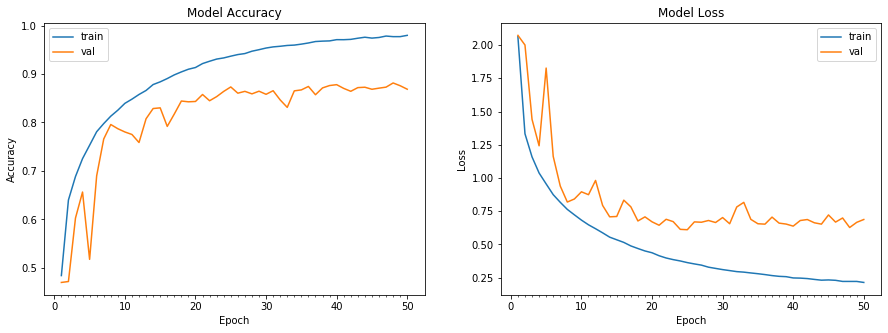

In [0]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
#else:
    #model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy



## Batch size of 256

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 32, 32, 32)   128         conv2d_41[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 32, 32, 32)   0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=195, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
195/195 [==============================] - 79s 408ms/step - loss: 2.2581 - acc: 0.4825 - val_loss: 4.5067 - val_acc: 0.2375
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
195/195 [==============================] - 60s 308ms/step - loss: 1.4167 - acc: 0.6410 - val_loss: 2.7954 - val_acc: 0.3765
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
195/195 [==============================] - 60s 307ms/step - loss: 1.2040 - acc: 0.6933 - val_loss: 1.4911 - val_acc: 0.6011
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
195/195 [==============================] - 60s 307ms/step - loss: 1.0615 - acc: 0.7372 - val_loss: 2.0102 - val_acc: 0.4964
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
195/195 [==============================] - 60s 307ms/step - loss: 0.9644 - acc: 0

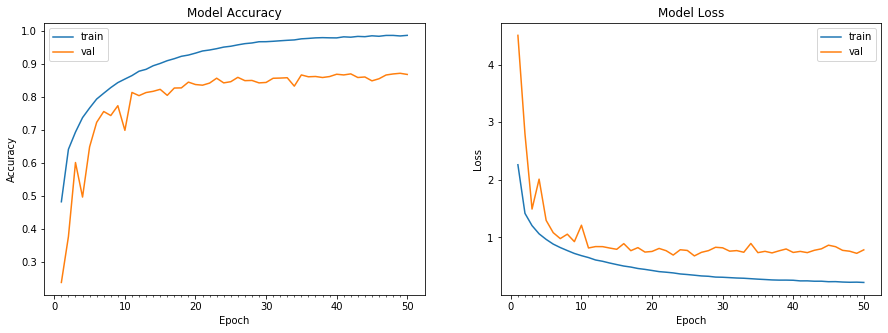

In [0]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
#else:
    #model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 256),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy



## Batch Size =32

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 32, 32, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 32, 32, 32)   128         conv2d_81[0][0]                  
__________________________________________________________________________________________________
activation_75 (Activation)      (None, 32, 32, 32)   0           batch_normalization_75[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=1562, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
1562/1562 [==============================] - 120s 77ms/step - loss: 1.8897 - acc: 0.4653 - val_loss: 1.7784 - val_acc: 0.4600
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
1562/1562 [==============================] - 103s 66ms/step - loss: 1.3646 - acc: 0.5982 - val_loss: 1.3647 - val_acc: 0.5965
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
1562/1562 [==============================] - 103s 66ms/step - loss: 1.2038 - acc: 0.6452 - val_loss: 1.3527 - val_acc: 0.5936
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
1562/1562 [==============================] - 103s 66ms/step - loss: 1.0959 - acc: 0.6804 - val_loss: 1.3198 - val_acc: 0.5984
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
1562/1562 [==============================] - 103s 66ms/step - loss: 1.008

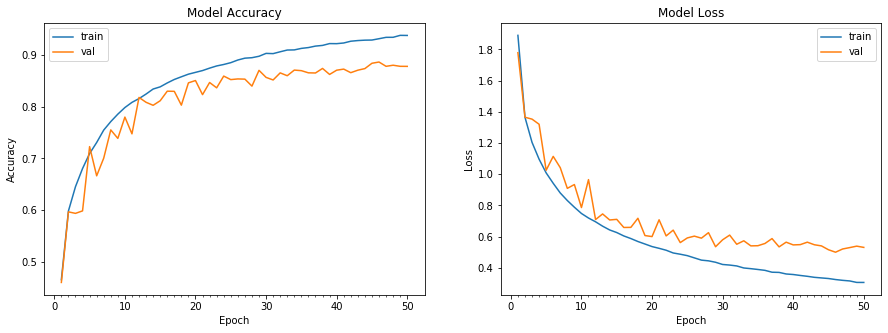

In [26]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
#else:
    #model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 32),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy


## Batch size 32 increased accuracy to 88.63
## Trying with batch size =16

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 32, 32, 32)   128         conv2d_121[0][0]                 
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 32, 32, 32)   0           batch_normalization_112[0][0]    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=3125, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
3125/3125 [==============================] - 191s 61ms/step - loss: 1.8909 - acc: 0.3959 - val_loss: 1.5887 - val_acc: 0.4534
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
3125/3125 [==============================] - 176s 56ms/step - loss: 1.4634 - acc: 0.5197 - val_loss: 1.3176 - val_acc: 0.5586
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
3125/3125 [==============================] - 174s 56ms/step - loss: 1.3496 - acc: 0.5605 - val_loss: 1.2107 - val_acc: 0.6073
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
3125/3125 [==============================] - 170s 55ms/step - loss: 1.2657 - acc: 0.5907 - val_loss: 1.2207 - val_acc: 0.6115
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
3125/3125 [==============================] - 170s 54ms/step - loss: 1.202

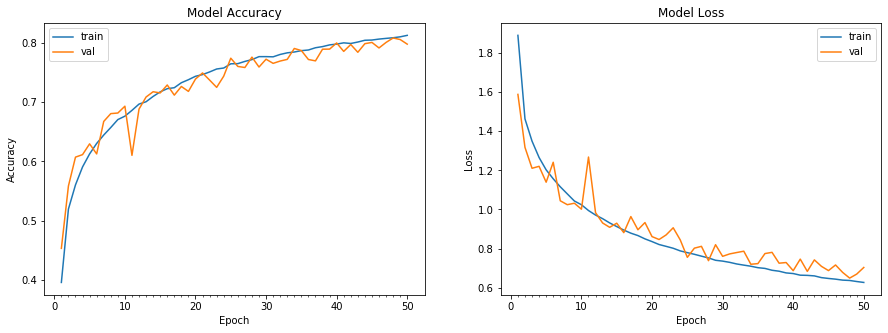

In [27]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
#else:
    #model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 16),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy


## Batch Size = 64

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 32, 32, 32)   128         conv2d_41[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 32, 32, 32)   0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=781, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
781/781 [==============================] - 99s 126ms/step - loss: 1.9422 - acc: 0.4892 - val_loss: 2.1549 - val_acc: 0.4039
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
781/781 [==============================] - 83s 106ms/step - loss: 1.3366 - acc: 0.6208 - val_loss: 1.4400 - val_acc: 0.5873
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
781/781 [==============================] - 83s 106ms/step - loss: 1.1823 - acc: 0.6676 - val_loss: 1.4344 - val_acc: 0.5824
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
781/781 [==============================] - 82s 105ms/step - loss: 1.0772 - acc: 0.6995 - val_loss: 1.2284 - val_acc: 0.6636
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
781/781 [==============================] - 82s 106ms/step - loss: 0.9954 - acc: 0

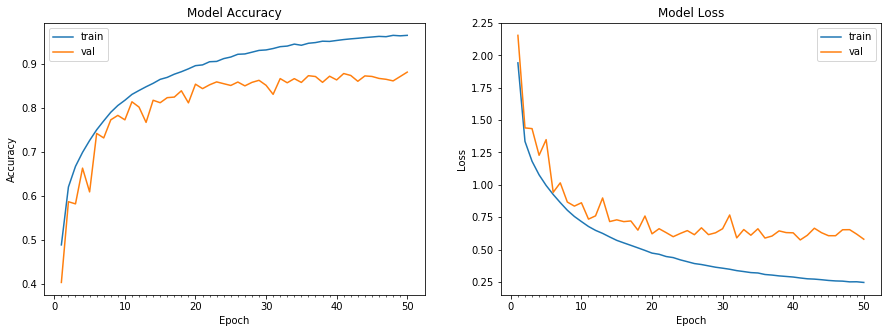

In [19]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
#else:
    #model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 64),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy


# GradCam

In [0]:
from keras.preprocessing import image
import numpy as np
import cv2

In [0]:
from keras.models import load_model

In [0]:
print(filepath)

/content/saved_models/cifar10_ResNet38v2_model.{epoch:03d}.h5


In [0]:
!ls

bin	 datalab  home	 lib64	opt   run   swift	      tmp    var
boot	 dev	  lib	 media	proc  sbin  sys		      tools
content  etc	  lib32  mnt	root  srv   tensorflow-2.0.0  usr


In [0]:
%cd content/saved_models/

[Errno 2] No such file or directory: 'content/saved_models/'
/content


In [0]:
%cd saved_models/

/content/saved_models


In [0]:
!ls

In [0]:
ResNet38V2 = load_model(filepath)

OSError: ignored

In [0]:
!ls

bin	 datalab  home	 lib64	opt   run   swift	      tmp    var
boot	 dev	  lib	 media	proc  sbin  sys		      tools
content  etc	  lib32  mnt	root  srv   tensorflow-2.0.0  usr


In [0]:
print(filepath)

/content/saved_models/cifar10_ResNet38v2_model.{epoch:03d}.h5


In [0]:
!cd saved_models/

/bin/bash: line 0: cd: saved_models/: No such file or directory


In [0]:
!pwd

/


In [0]:
cd ..

/


In [0]:
!pwd

/


In [0]:
!cd /content/saved_models
!pwd

/


In [0]:
!cd content/

In [0]:
!cd saved_models

/bin/bash: line 0: cd: saved_models: No such file or directory


In [0]:
!ls

bin	 datalab  home	 lib64	opt   run   swift	      tmp    var
boot	 dev	  lib	 media	proc  sbin  sys		      tools
content  etc	  lib32  mnt	root  srv   tensorflow-2.0.0  usr
